In [1]:
import pandas as pd
import json
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import stanza
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(20,12)})

#stanza.download('da')
#nltk.download('stopwords')

In [5]:
import_cols = ['created_at', 'id', 'full_text', 'entities', 'user', 'retweeted_status', 'is_quote_status', 'retweet_count', 
            'favorite_count', 'favorited', 'retweeted']

user_infos = ['id', 'name', 'screen_name', 'location', 'description', 'url', 'followers_count', 'created_at', 'verified']

keep_cols = ['created_at', 'id', 'full_text', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted',
            'is_retweet', 'hashtags', 'user_mentions', 'urls'] + ["user_" + user_info for user_info in user_infos]

#savepath = os.path.join('C:/', 'data', 'poltweets', "tweets_flattened_20200127.gz")
#datapath = os.path.join('C:/', 'data', 'poltweets', "tweets_flattened_20200127.gz")
datapath = os.path.join('D:/', 'data', 'poltweets', "tweets_flattened_20200127.gz")
matpath = os.path.join('..','..', 'material')

In [6]:
nlp = stanza.Pipeline('da', processors = 'tokenize,pos') # no sentiment analysis for Danish

2021-03-09 08:38:02 INFO: Loading these models for language: da (Danish):
| Processor | Package |
-----------------------
| tokenize  | ddt     |
| pos       | ddt     |

2021-03-09 08:38:02 INFO: Use device: cpu
2021-03-09 08:38:02 INFO: Loading: tokenize
2021-03-09 08:38:02 INFO: Loading: pos
2021-03-09 08:38:03 INFO: Done loading processors!


In [7]:
# Load data
data = pd.read_csv(datapath, index_col = 0)

In [8]:
# Politicians
polparty = pd.read_csv(os.path.join(matpath, 'politicians_party.csv'))
poldict = polparty.groupby('navn')['parti'].apply(list).to_dict()

In [9]:
# Functions

custom_stopwords = ['mere', 'flere']
stopWords = set(stopwords.words('danish') + custom_stopwords)

def get_party(user):
    """
    Find political party based on fuzzy string matching on name.
    """
    similarity = 0

    for k,v in poldict.items():
        newsim = fuzz.ratio(user, k)
        if newsim > similarity:
            similarity = newsim
            party = v[0]
    return(party)

def tokenizer_custom(text):
    """
    Tokenizer function.
    """
    doc = nlp(text.lower())
    
    tag_match = re.compile(r'(?!^\@|^\#)')
    
    pos_tags = ['NOUN'] # Keep adjectives and nouns
    
    tokens = []
      
    for sentence in doc.sentences:
        for word in sentence.words:
            if (word.pos in pos_tags) & (word.text not in stopWords):
                token = word.text # Returning the lemma of the word in lower-case.
                tokens.append(token)
    
    tokens = list(filter(tag_match.match, tokens))
    
    return(tokens)

def climate_match(string):
    regex = re.compile(r'.*klima.*|.*miljø.*', re.IGNORECASE)
    
    if regex.match(string):
        return True
    else:
        return False

In [10]:
# Adding party variable

users = list(data['user_name'].unique())

userparty = pd.DataFrame({'username': pd.Series(users), 'party': pd.Series(users).apply(get_party)})
userparty_dict = dict(zip(userparty['username'], userparty['party']))

data['party'] = data['user_name'].copy().replace(userparty_dict)

In [11]:
# Format date variable and sort

data['created_at'] = pd.to_datetime(data['created_at'], format = "%a %b %d %H:%M:%S %z %Y")
data = data.sort_values('created_at')

In [12]:
# Adding year_month variable

data['year_month'] = data['created_at'].dt.to_period('M')

C:\programs\Anaconda3\envs\tm\lib\site-packages\pandas\core\arrays\datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [13]:
data.head()

,created_at,id,full_text,is_quote_status,retweet_count,favorite_count,favorited,retweeted,is_retweet,hashtags,...,user_name,user_screen_name,user_location,user_description,user_url,user_followers_count,user_created_at,user_verified,party,year_month
133845,2009-01-30 08:54:54+00:00,1161162679,@werdelin fuck hvor er det trist. mødte du ham...,False,0,0,False,False,False,[],...,Tommy Ahlers,aahlers,Copenhagen,Medlem af Folketinget. Iværksætter og angel in...,https://t.co/CYtLhwLqAU,22871,Fri Jan 30 08:52:06 +0000 2009,True,Venstre,2009-01
133844,2009-03-20 11:45:11+00:00,1359777875,been talking about twitter for 2 years. I've b...,False,0,0,False,False,False,[],...,Tommy Ahlers,aahlers,Copenhagen,Medlem af Folketinget. Iværksætter og angel in...,https://t.co/CYtLhwLqAU,22871,Fri Jan 30 08:52:06 +0000 2009,True,Venstre,2009-03
133843,2009-03-20 11:49:38+00:00,1359792137,@gustavs good start of the day. see you soon f...,False,0,0,False,False,False,[],...,Tommy Ahlers,aahlers,Copenhagen,Medlem af Folketinget. Iværksætter og angel in...,https://t.co/CYtLhwLqAU,22871,Fri Jan 30 08:52:06 +0000 2009,True,Venstre,2009-03
133842,2009-03-20 13:31:53+00:00,1360188697,@zyb looking forward to the race tonight. watc...,False,0,0,False,False,False,[],...,Tommy Ahlers,aahlers,Copenhagen,Medlem af Folketinget. Iværksætter og angel in...,https://t.co/CYtLhwLqAU,22871,Fri Jan 30 08:52:06 +0000 2009,True,Venstre,2009-03
133841,2009-03-23 08:02:30+00:00,1374497053,in munich airport way to early waiting for my ...,False,0,0,False,False,False,[],...,Tommy Ahlers,aahlers,Copenhagen,Medlem af Folketinget. Iværksætter og angel in...,https://t.co/CYtLhwLqAU,22871,Fri Jan 30 08:52:06 +0000 2009,True,Venstre,2009-03


In [14]:
df = data.loc[(data['is_retweet'] == False) & (data['created_at'].dt.year >= 2015),:]

In [14]:
# Tweets over time

df_grouped = df.groupby(pd.PeriodIndex(df['created_at'], freq='D'))
results = df_grouped.size().to_frame(name = 'count')
idx = pd.period_range(min(results.index), max(results.index))
results = results.reindex(idx, fill_value = 0)
results['year_week'] = results.index.to_timestamp()
results['year_week'] = results['year_week'].dt.year.astype(str) + "-" + results['year_week'].dt.isocalendar().week.astype(str).str.pad(width = 2, fillchar = '0')

week_counts = results.groupby('year_week')['count'].sum().to_frame(name = 'count').reset_index()

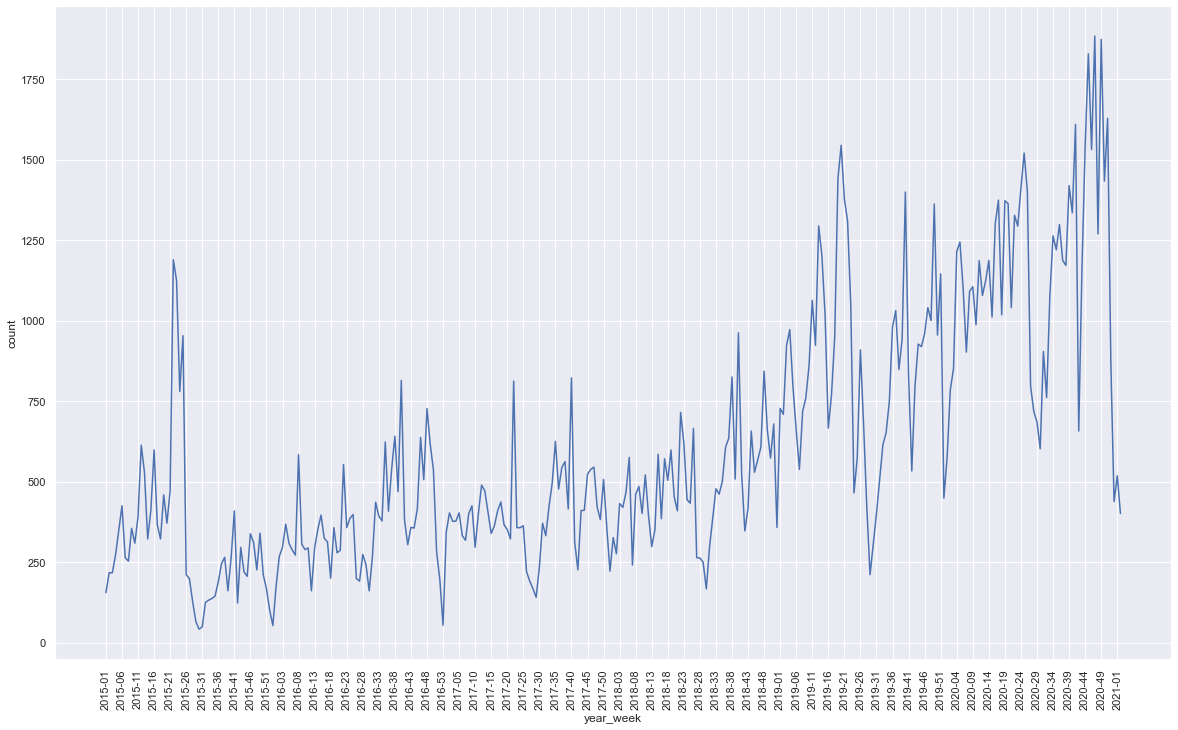

In [21]:
sns.lineplot(data = week_counts, x = 'year_week', y = 'count')
locs, labels = plt.xticks()
plt.xticks(ticks = locs[::5], rotation = 90)
plt.show()

<AxesSubplot:xlabel='party'>

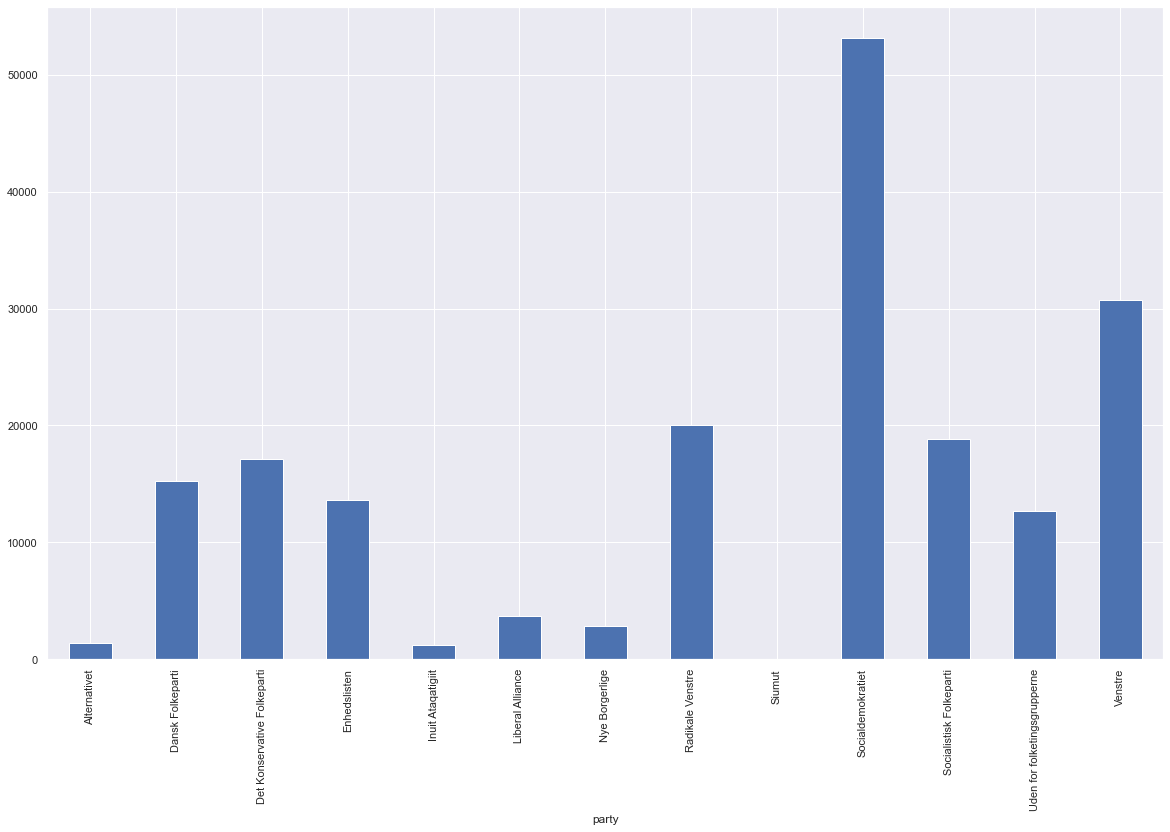

In [22]:
# Parties tweet

df.groupby('party').size().plot.bar()

In [23]:
idx = pd.period_range(start='2015-01-01', end='2020-12-01', freq='M')

months = pd.DataFrame(data = {'year_month': idx, 'party': [list(df['party'].unique())] * len(idx), 'count': 0})
months = months.explode('party')

In [24]:
df_grouped = df.groupby(['party', 'year_month']).size().to_frame(name = 'count')

df_partymonths = df_grouped.join(months.set_index(['year_month', 'party']), how = 'right', rsuffix = "_right").reset_index().drop('count_right', axis = 1).fillna(0)
df_partymonths['year_month'] = df_partymonths['year_month'].astype(str)

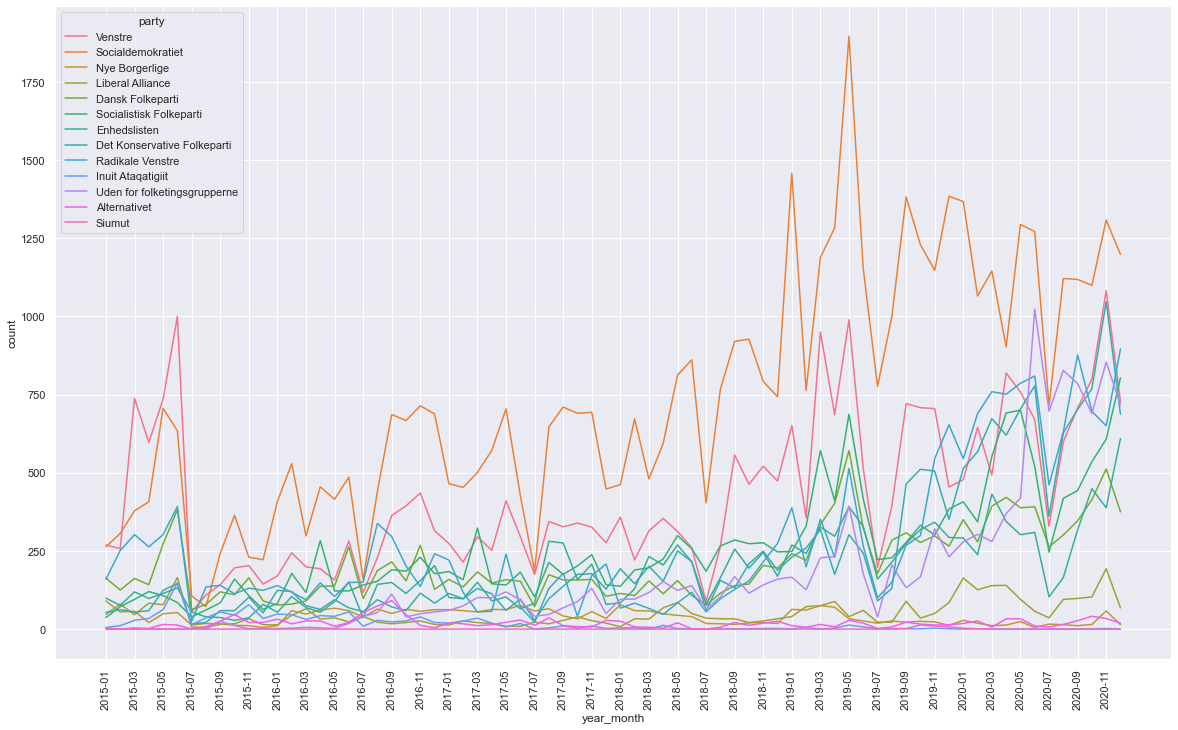

In [25]:
sns.lineplot(data = df_partymonths, x = 'year_month', y = 'count', hue = 'party')
locs, labels = plt.xticks()
plt.xticks(ticks = locs[::2], rotation = 90)
plt.show()

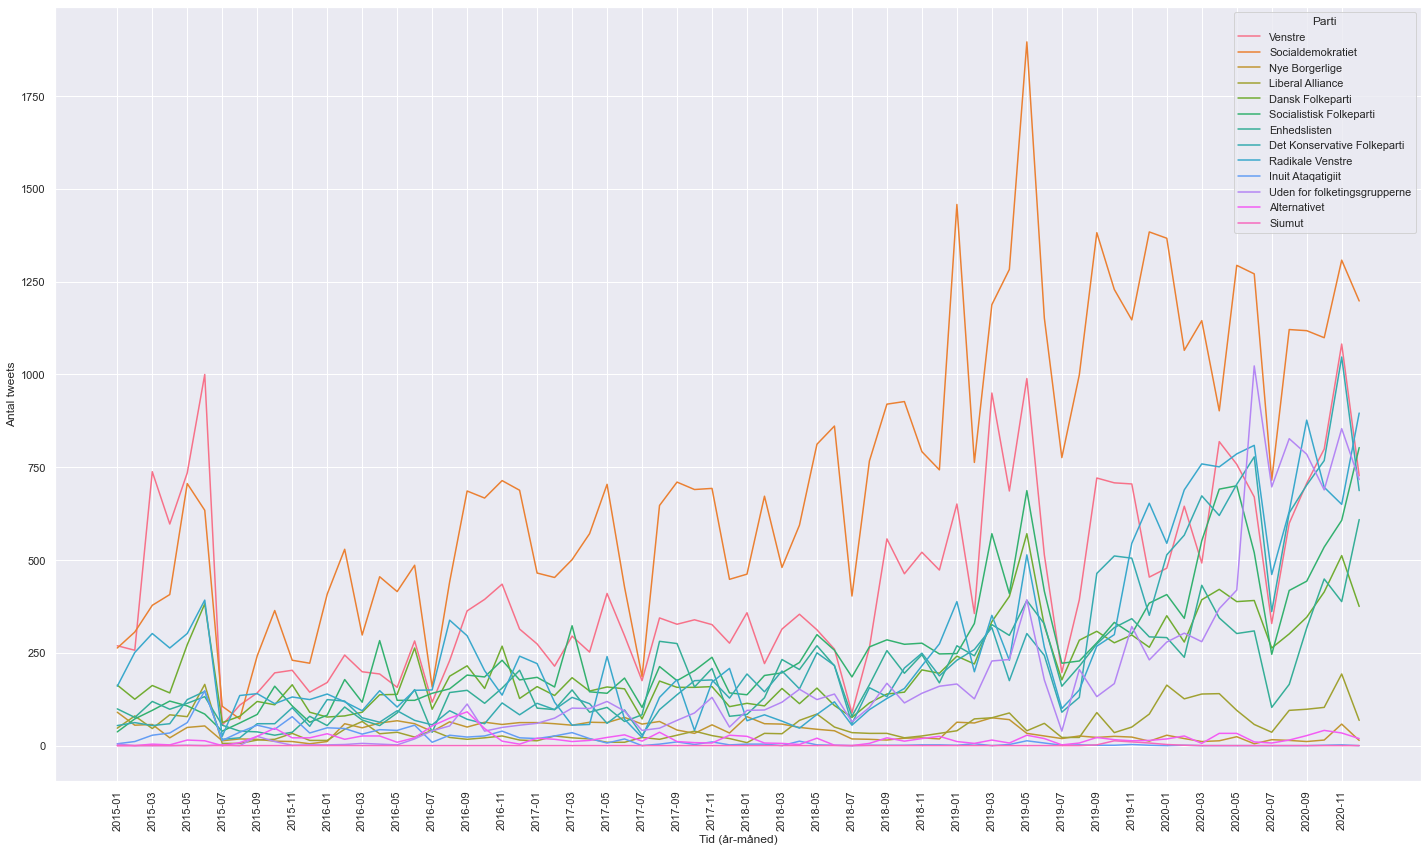

In [31]:
sns.lineplot(data = df_partymonths, x = 'year_month', y = 'count', hue = 'party')
locs, labels = plt.xticks()
plt.xticks(ticks = locs[::2], rotation = 90)
plt.xlabel("Tid (år-måned)")
plt.ylabel("Antal tweets")
plt.legend(title = "Parti")
plt.tight_layout()
plt.savefig('pol_tweet-activity.png', dpi = 200)

In [33]:
# Creating sample

sample = data.loc[(data['is_retweet'] == False) & (data['created_at'].dt.year >= 2015),:].sample(n = 10000, random_state = 42).reset_index(drop = True)

sample['talk_climate'] = sample['full_text'].apply(lambda x: climate_match(x))

df = sample.loc[sample['talk_climate'], :].reset_index(drop = True).sort_values('created_at')

print(df.shape)
df.head()

(301, 24)


,created_at,id,full_text,is_quote_status,retweet_count,favorite_count,favorited,retweeted,is_retweet,hashtags,...,user_screen_name,user_location,user_description,user_url,user_followers_count,user_created_at,user_verified,party,year_month,talk_climate
237,2015-01-06 10:48:29+00:00,552416405094924300,"Unge: Det er ikke klimaforandringer i Danmark,...",False,3,6,False,False,False,['DetHandlerOmMennesker'],...,rasmushelveg,NaN,"MF, radikale venstre. Socialordfører. Fhv udvi...",NaN,5138,Thu Nov 21 11:29:54 +0000 2013,True,Radikale Venstre,2015-01,True
219,2015-01-08 21:03:43+00:00,553296012484550660,Ej KTD. Vi havde også terrorisme og forrådede ...,False,1,4,False,False,False,['drdemokrati'],...,JeppeBruus,"Gladsaxe, Gentofte, KBH Omegn","Sosse, MF, Retsordfører, Formand for Transport...",NaN,3407,Thu Nov 26 12:37:38 +0000 2009,False,Socialdemokratiet,2015-01,True
221,2015-03-24 10:03:45+00:00,580309013717499900,@valdemar1997 vi arbejder på sagen og benzinbi...,False,0,0,False,False,False,['dkgreen'],...,rasmushelveg,NaN,"MF, radikale venstre. Socialordfører. Fhv udvi...",NaN,5138,Thu Nov 21 11:29:54 +0000 2013,True,Radikale Venstre,2015-03,True
121,2015-04-04 15:14:38+00:00,584373519905067000,.@leander_ina EU først og fremmest - indenfor ...,False,1,0,False,False,False,['SpørgHelveg'],...,rasmushelveg,NaN,"MF, radikale venstre. Socialordfører. Fhv udvi...",NaN,5138,Thu Nov 21 11:29:54 +0000 2013,True,Radikale Venstre,2015-04,True
128,2015-04-25 06:37:24+00:00,591853495386579000,Kommuner og miljøorganisationer må sammen opfo...,False,0,0,False,False,False,['dkpol'],...,TrineTorp,tlf: 61624594,MF for SF. Social- og psykiatriordfører.,https://t.co/ixFX378KtR,3560,Tue Aug 13 12:16:31 +0000 2013,True,Socialistisk Folkeparti,2015-04,True


In [39]:
# All data except retweets 2015-2020
df['talk_climate'] = df['full_text'].apply(lambda x: climate_match(x))
df_climate = df.loc[df['talk_climate'], :].reset_index(drop = True).sort_values('created_at')

C:\Users\kgk\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
df_climate.shape

(6032, 24)

In [48]:
df_climate.loc[5600, "full_text"]

'Det står dælme sløjt til med regeringens klimaambitioner på biler. Kom nu! Hvor vil I finde de store reduktioner, hvis heller ikke her? #dkgreen #dkpol https://t.co/t4MA15GCwt'

In [28]:
# Tokenizing

df_climate['tokens'] = df_climate['full_text'].apply(tokenizer_custom)

In [131]:
climate_regex = re.compile(r'.*klima.*', re.IGNORECASE)

df_climate['climate_tokens'] = df_climate['tokens'].apply(lambda tokens: [token for token in tokens if climate_regex.match(token)])

In [165]:
# Top climate

df_climate.explode('climate_tokens')['climate_tokens'].value_counts()[0:20]

klima                  778
klimaet                581
klimalov               228
klimakrisen            213
klimahandling          136
klimapolitik           128
klimaplan              126
klimamål               116
klimarådet             115
klimaforandringerne    106
klimaloven              90
klimaforandringer       83
klimakampen             83
klimaaftale             51
klimaindsats            50
klimarådets             46
klimaets                44
klimaudspil             41
klimaambitioner         39
klimaministeren         37
Name: climate_tokens, dtype: int64

In [176]:
# Top climate words = klima/klimaet, klimalov, klimakrisen, klimahandling, klimapolitik

In [172]:
# Tidy text - network format

df_climate['tokens2'] = df_climate['tokens'].copy()
df_long = df_climate.explode('tokens').reset_index(drop = True)
df_long = df_long.explode('tokens2').reset_index(drop = True)
df_long = df_long.explode('climate_tokens').reset_index(drop = True)

df_long = df_long.loc[df_long['tokens'] != df_long['tokens2'], :]
df_long = df_long.dropna(subset = ['climate_tokens'])

df_long['tokens'] = df_long['tokens'].astype(str)
df_long['tokens2'] = df_long['tokens2'].astype(str)
df_long['climate_tokens'] = df_long['climate_tokens'].astype(str)
df_long.loc[df_long['climate_tokens'] == 'klimaet', 'climate_tokens'] = 'klima'
df_long.loc[df_long['tokens'] == 'klimaet', 'tokens'] = 'klima'
df_long.loc[df_long['tokens2'] == 'klimaet', 'tokens2'] = 'klima'

In [173]:
df_long.head()

,created_at,id,full_text,is_quote_status,retweet_count,favorite_count,favorited,retweeted,is_retweet,hashtags,...,user_url,user_followers_count,user_created_at,user_verified,party,year_month,talk_climate,tokens,climate_tokens,tokens2
1,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,verdens,erhvervsklima,erhvervsklima
2,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,verdens,erhvervsklima,grundlaget
3,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,verdens,erhvervsklima,vækst
4,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,verdens,erhvervsklima,arbejdspladser
5,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,erhvervsklima,erhvervsklima,verdens


In [177]:
specific_stops = ['grønne', 'år', 'godt', 'bedre', 'store', 'dag', 'tak', 'nye', 'ny', 'gang', 'brug', 'løkke', 'går', 'vej', 'dk', 'm', 'mio', 'del']

df_filter = df_long.loc[df_long['tokens'].apply(lambda token: (token not in specific_stops))].reset_index(drop = True)

In [178]:
top_words = df_filter['tokens'].value_counts()[0:20]
top_words

klima            11197
regeringen        3574
klimalov          2288
klimakrisen       2038
omstilling        1685
klimahandling     1524
handling          1413
mål               1291
klimarådet        1287
regeringens       1244
klimaplan         1194
co2               1163
klimamål          1129
miljø             1047
penge             1037
klimaloven         999
natur              993
klimapolitik       991
politik            981
verden             942
Name: tokens, dtype: int64

In [179]:
# Network

df_network = df_filter.copy()

In [180]:
#df_network.loc[df_network['climate_tokens'].str.contains('klima'), 'climate_tokens'] = "klima*"
#df_network.loc[df_network['climate_tokens'].str.contains('miljø'), 'climate_tokens'] = "miljø*"

In [181]:
df_network.head()

,created_at,id,full_text,is_quote_status,retweet_count,favorite_count,favorited,retweeted,is_retweet,hashtags,...,user_url,user_followers_count,user_created_at,user_verified,party,year_month,talk_climate,tokens,climate_tokens,tokens2
0,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,verdens,erhvervsklima,erhvervsklima
1,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,verdens,erhvervsklima,grundlaget
2,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,verdens,erhvervsklima,vækst
3,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,verdens,erhvervsklima,arbejdspladser
4,2015-01-02 18:15:48+00:00,551079426495361000,I #DetDanmarkDuKender har vi verdens bedste er...,False,1,3,False,False,False,"['DetDanmarkDuKender', 'dkpol']",...,NaN,6706,Thu May 07 13:29:26 +0000 2009,False,Socialdemokratiet,2015-01,True,erhvervsklima,erhvervsklima,verdens


In [182]:
df_network['climate_tokens'].value_counts()[0:30]

klima                   75029
klimakrisen             11327
klimalov                10121
klimahandling            7317
klimaplan                6528
klimarådet               6069
klimamål                 5786
klimapolitik             5176
klimaloven               4469
klimaforandringerne      4420
klimaforandringer        3905
klimaindsats             3331
klimarådets              3298
klimakampen              2812
klimaaftale              2500
klimaets                 2360
klimaministeren          2273
klimaudspil              2188
klimakrise               2041
klimaindsatsen           1623
klimaambitioner          1533
klimaforhandlinger       1454
klimafond                1392
klimabelastning          1381
klimaeffekt              1374
klimatiltag              1335
klimapolitikken          1206
klimaområdet             1196
klimamålet               1184
klimaforhandlingerne     1065
Name: climate_tokens, dtype: int64

In [183]:
# Save

datadir = os.path.join('C:/', 'data', 'poltweets')
savedir = os.path.join(datadir, 'climate-tweets_network.csv')

df_network.to_csv(savedir, index = False)

In [89]:
top_words = df_network['climate_tokens'].value_counts().index[0:20]

In [90]:
df_network_top = df_network.loc[df_network['climate_tokens'].apply(lambda token: token in top_words), :]

In [120]:
df_network_count = df_network_top.groupby(['tokens']).size().to_frame(name = 'count').reset_index()
df_network_count = df_network_count.loc[df_network_count['count'] <= 20]
remove_tokens = list(df_network_count['tokens'])

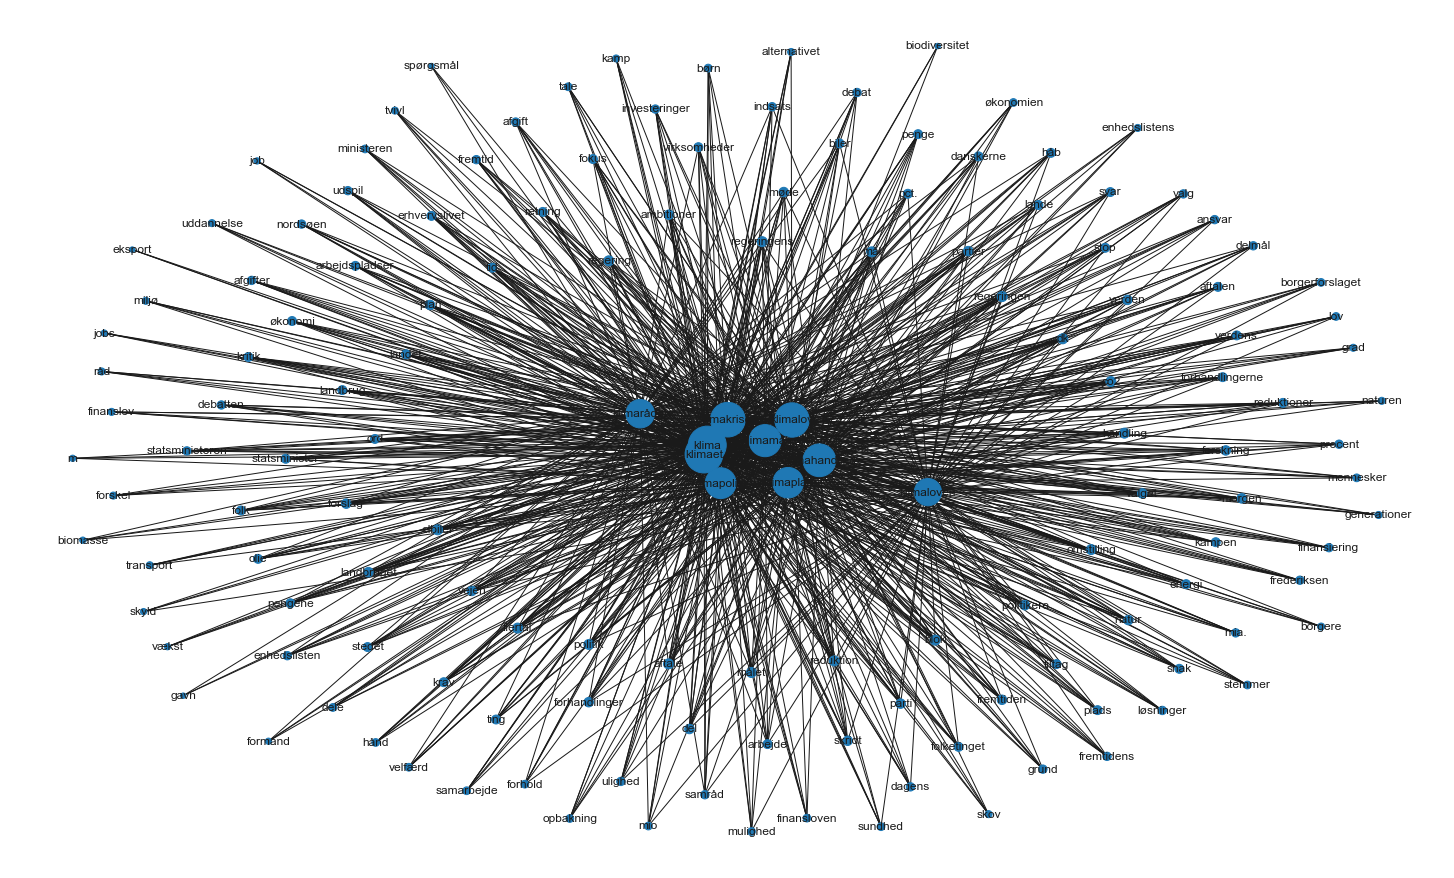

In [121]:
import networkx as nx

G = nx.from_pandas_edgelist(df_network_top, 'climate_tokens', 'tokens')
G.remove_nodes_from(remove_tokens)
degree_cent = dict(G.degree)


nx.draw(G, pos=nx.kamada_kawai_layout(G), nodelist=degree_cent.keys(), node_size=[v * 10 for v in degree_cent.values()], with_labels=True)

#nx.draw(G, pos=nx.kamada_kawai_layout(G))
#nx.draw(G, nodelist = list(df_networknode_size = list(df_network['weight']))